<a href="https://colab.research.google.com/github/Ersel26/LendingClub_loan_prediction/blob/main/LendingClub_loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

Read the Data and examine it

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lending club/lending_club_loan_two.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [3]:
def convert_status(status):
    if status == "Fully Paid":
        return 1
    if status == "Charged Off":
        return 0

df["loan_repaid"] = df["loan_status"].apply(convert_status)

In [4]:
nulls = df.isnull().sum()
nulls = nulls.apply(lambda x: 100*(x/len(df)))
print(nulls)

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64


In [5]:
print(df["emp_title"].nunique())

173105


In [6]:
df.drop("emp_title", axis = 1, inplace = True)

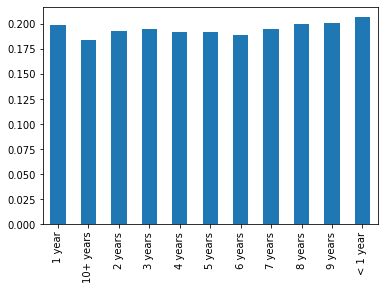

In [7]:
emp_co = df[df["loan_status"] == "Charged Off"]["emp_length"].value_counts()
emp_total = df["emp_length"].value_counts()

emp_len = emp_co/emp_total

emp_len.plot(kind = "bar")

In [8]:
df.drop("emp_length", axis = 1, inplace = True)

In [9]:
print(df['purpose'].head(10))
print("\n")
print(df['title'].head(10))

0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object


0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object


In [10]:
df.drop("title", axis = 1, inplace = True)

In [11]:
df.corr()["mort_acc"].sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [12]:
mort_from_total = df.groupby("total_acc")["mort_acc"].mean()
def fill_mort(mort, total):
    if np.isnan(mort):
        return mort_from_total[total]
    else:
        return mort
    
df["mort_acc"] = df.apply(lambda x: fill_mort(x["mort_acc"],x["total_acc"]), axis = 1)

In [13]:
df.dropna(inplace = True)

In [14]:
df.select_dtypes(include = ["object"]).columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [15]:
df["term"] = df["term"].apply(lambda x: int(x[1:3]))


In [16]:
df.drop("grade", axis = 1, inplace = True)

In [17]:
def convert_one_hot(df, feature_list):
    for i in feature_list:
        dummies = pd.get_dummies(df[i], drop_first = True)
        df = pd.concat([df.drop(i, axis = 1), dummies], axis = 1)

    return df

In [18]:
feature_list = ["sub_grade", "verification_status", "application_type", "initial_list_status", "purpose"]

In [19]:
df["home_ownership"] = df["home_ownership"].replace(["NONE", "ANY"], "OTHER")
feature_list.append("home_ownership")

In [20]:
df["zip_code"] = df["address"].apply(lambda x: x[-5:])
df.drop("address", axis = 1, inplace = True)
feature_list.append("zip_code")

In [21]:
df["earliest_cr_year"] = df["earliest_cr_line"].apply(lambda x: int(x[-4:]))
df.drop("earliest_cr_line", axis = 1, inplace = True)

In [22]:
df.drop("issue_d", axis = True, inplace = True)

In [23]:
df = convert_one_hot(df, feature_list)

In [24]:
df.drop("loan_status", axis = 1, inplace = True)

In [25]:
X = df.drop("loan_repaid", axis = 1)
y = df["loan_repaid"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [26]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
model = Sequential()

model.add(Dense(78, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(39, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(19, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer = "adam", loss ="binary_crossentropy")

In [28]:
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 5)

In [29]:
model.fit(x = X_train, 
          y = y_train, 
          batch_size = 256, 
          epochs = 25, 
          validation_data = (X_test, y_test),
          callbacks = [early_stop])

Epoch 1/25
1236/1236 [==============================] - 6s 4ms/step - loss: 0.2984 - val_loss: 0.2648
Epoch 2/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2651 - val_loss: 0.2629
Epoch 3/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2628 - val_loss: 0.2629
Epoch 4/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2615 - val_loss: 0.2619
Epoch 5/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2607 - val_loss: 0.2619
Epoch 6/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2605 - val_loss: 0.2617
Epoch 7/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2600 - val_loss: 0.2615
Epoch 8/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2595 - val_loss: 0.2615
Epoch 9/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.2593 - val_loss: 0.2616
Epoch 10/25
1236/1236 [==============================] - 5s 4ms/step - loss: 0.258

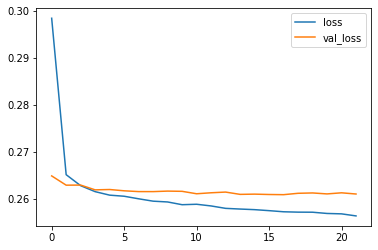

In [30]:
pd.DataFrame(model.history.history).plot()

In [32]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [33]:
print(classification_report(y_test, predictions))
print("\n")
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.46      0.62     15658
           1       0.88      0.99      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.92      0.73      0.78     79044
weighted avg       0.89      0.89      0.87     79044



[[ 7202  8456]
 [  390 62996]]
